In [2]:
!nvidia-smi

Wed Mar 16 06:47:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dense,Dropout,Flatten,Lambda,Input
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [5]:
#! pip install tensorflow_hub
#!pip install tensorflow-gpu

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [8]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [9]:
IMAGE_SIZE=224
train_path='/content/drive/MyDrive/Data Science project/cotton Disease pred/train'
test_path='/content/drive/MyDrive/Data Science project/cotton Disease pred/test'

In [10]:
resnet=ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),weights='imagenet',include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
#here we have existing weights and they are trained so we dont want to train our weights.we just want to train our last layer
for layer in resnet.layers:
  layer.trainable=False

In [12]:
#useful in getting no of output classes
folders=glob('/content/drive/MyDrive/Data Science project/cotton Disease pred/train/*')

In [13]:
X=Flatten()(resnet.output)


In [14]:
prediction=Dense(len(folders),activation='softmax')(X)

In [15]:
model= Model(inputs=resnet.input,outputs=prediction)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
#Data Augmentation
train_data=ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)
test_data=ImageDataGenerator(rescale=1./255)

In [19]:
train_dataset=train_data.flow_from_directory('/content/drive/MyDrive/Data Science project/cotton Disease pred/train',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 1345 images belonging to 4 classes.


In [20]:
test_dataset=test_data.flow_from_directory('/content/drive/MyDrive/Data Science project/cotton Disease pred/test',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 12 images belonging to 4 classes.


In [68]:
train_dataset.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [70]:
#this shows augumented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

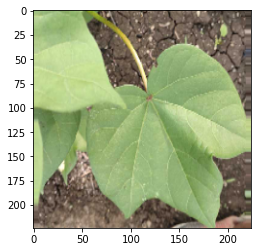

In [83]:
plt.imshow(train_dataset[0][0][0])

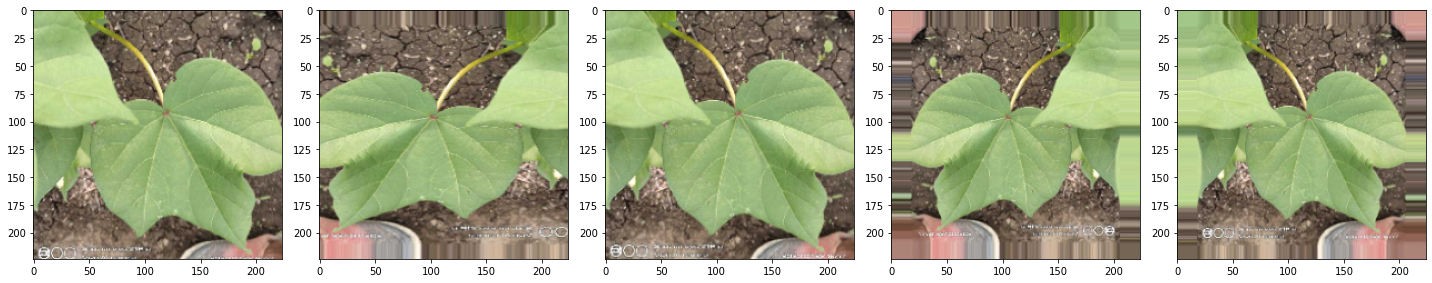

In [72]:
images = [train_dataset[0][0][0] for i in range(5)]
plotImages(images)

In [86]:
import keras
from keras.callbacks import ModelCheckpoint

In [87]:
model_path = '/content/drive/MyDrive/Data Science project/cotton Disease pred/cotton_disease_pred_model.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
r=model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=len(train_dataset),
    validation_steps=len(test_dataset)
)

Epoch 1/20
43/43 [==============================] - 176s 4s/step - loss: 1.7176 - accuracy: 0.4022 - val_loss: 8.9516 - val_accuracy: 0.5833
Epoch 2/20
43/43 [==============================] - 31s 729ms/step - loss: 1.0547 - accuracy: 0.5138 - val_loss: 8.5768 - val_accuracy: 0.8333
Epoch 3/20
43/43 [==============================] - 31s 723ms/step - loss: 0.8724 - accuracy: 0.6439 - val_loss: 9.0330 - val_accuracy: 0.5000
Epoch 4/20
43/43 [==============================] - 31s 747ms/step - loss: 1.0102 - accuracy: 0.6506 - val_loss: 8.5499 - val_accuracy: 0.7500
Epoch 5/20
43/43 [==============================] - 31s 724ms/step - loss: 0.6417 - accuracy: 0.6900 - val_loss: 8.5588 - val_accuracy: 0.8333
Epoch 6/20
43/43 [==============================] - 31s 722ms/step - loss: 0.7869 - accuracy: 0.6699 - val_loss: 8.4845 - val_accuracy: 0.8333
Epoch 7/20
43/43 [==============================] - 31s 720ms/step - loss: 0.5857 - accuracy: 0.7286 - val_loss: 8.7836 - val_accuracy: 0.6667
E

In [32]:
loss=r.history['loss']
val_loss=r.history['val_loss'],
acc=r.history['accuracy']
val_acc=r.history['val_accuracy']

In [31]:
EPOCHS=20

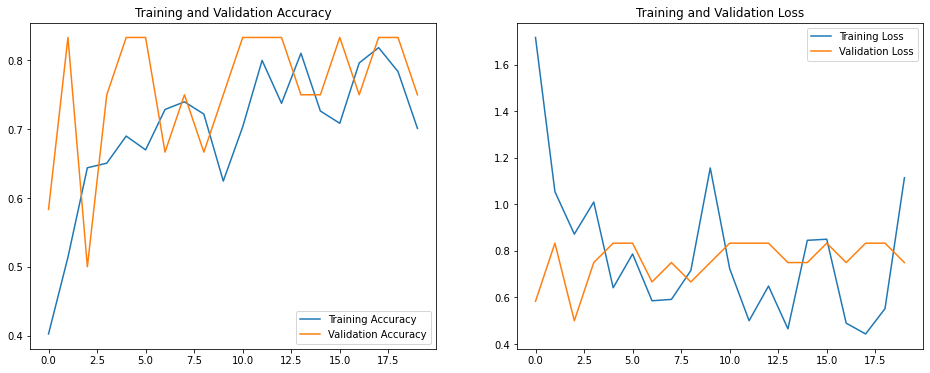

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
from tensorflow.keras.models import load_model

In [58]:
model.save('/content/drive/MyDrive/Data Science project/cotton Disease pred/model_resent50.h5')

In [59]:
y_pred = model.predict(test_dataset)

In [60]:
y_pred

array([[0.0000000e+00, 3.4376618e-01, 4.0701273e-04, 6.5582681e-01],
       [0.0000000e+00, 7.9476953e-02, 5.7384187e-01, 3.4668118e-01],
       [0.0000000e+00, 9.9473393e-01, 2.1036263e-05, 5.2450448e-03],
       [0.0000000e+00, 9.9161971e-01, 1.1858274e-03, 7.1944813e-03],
       [0.0000000e+00, 5.4357213e-01, 2.6747480e-01, 1.8895309e-01],
       [0.0000000e+00, 9.9955004e-01, 2.1428859e-08, 4.4990669e-04],
       [0.0000000e+00, 2.7997990e-04, 2.3990432e-03, 9.9732095e-01],
       [0.0000000e+00, 1.1293227e-03, 9.9878329e-01, 8.7407185e-05],
       [0.0000000e+00, 2.4025361e-01, 7.4490899e-01, 1.4837429e-02],
       [0.0000000e+00, 1.0720005e-03, 9.6499747e-01, 3.3930518e-02],
       [0.0000000e+00, 9.9507195e-01, 1.1317511e-07, 4.9279695e-03],
       [0.0000000e+00, 9.9860293e-01, 2.4450494e-05, 1.3726777e-03]],
      dtype=float32)

In [61]:
y_pred=np.argmax(y_pred,axis=1)

In [62]:
y_pred

array([3, 2, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1])

In [63]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [65]:
model=load_model('/content/drive/MyDrive/Data Science project/cotton Disease pred/model_resent50.h5')